# Algoritmo de Grover

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.quantum_info import Statevector

In [2]:
# Definição do operador de Marcação Uf

def op_marcacao(n, omega, barrier = False):
    
    assert omega <2**n, f'{omega} não pode ser representado com {n} qubits'
    
    bin_omega = bin(omega)[2:]
    bin_omega = '0' * (n - len(bin_omega)) + bin_omega
    
    
    c_marcacao = QuantumCircuit(n)
    
    for i, wi in enumerate(bin_omega):
        if wi == '0':
            c_marcacao.x(i)
        else:
            c_marcacao.i(i)

            
    if barrier:
        c_marcacao.barrier()
    
    # Porta Z condicionada aos qubits de cima
    c_marcacao.h(n-1)
    c_marcacao.mct(list(range(n-1)), n-1)
    c_marcacao.h(n-1)
    
    
    if barrier:
        c_marcacao.barrier()

    
    for i, wi in enumerate(bin_omega):
        if wi == '0':
            c_marcacao.x(i)
        else:
            c_marcacao.i(i)
    
    return c_marcacao

In [3]:
# Definição do operador de Difusão V

def op_difusao(n, barrier = False):

     
    c_difusao = QuantumCircuit(n)
    
    
    c_difusao.h(range(n))
    c_difusao.x(range(n))

            
    if barrier:
        c_difusao.barrier()
    
    # Porta Z condicionada aos qubits de cima
    c_difusao.h(n-1)
    c_difusao.mct(list(range(n-1)), n-1)
    c_difusao.h(n-1)
    
    
    if barrier:
        c_difusao.barrier()

    
    c_difusao.x(range(n))
    c_difusao.h(range(n))
    
    return c_difusao

In [4]:
# Parametros do circuito

n = 5

omega = 12

r = round((np.pi / (4 * np.arcsin(1 / np.sqrt(2 ** n)))) - (1 / 2))

Operador de Marcação


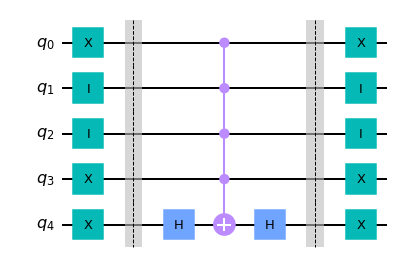

In [5]:
print("Operador de Marcação")

op_marcacao(n, omega, True).draw('mpl')

Operador de Difusão


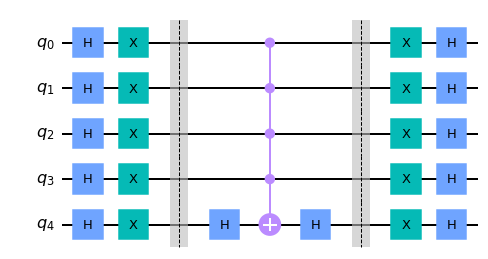

In [6]:
print("Operador de Difusão")

op_difusao(n, True).draw('mpl')

In [7]:
# Criação das portas que implementam os operadores de marcação e difusão

Uf = op_marcacao(n, omega).to_gate()
Uf.name = '$U_f$'

V = op_difusao(n).to_gate()
V.name = '$V$'

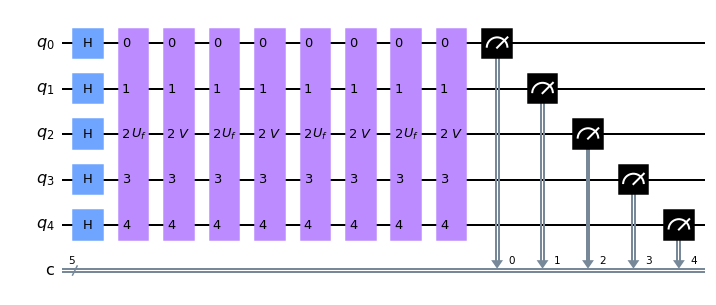

In [51]:
# Definição do Circuito para Aplicação do Algoritmo de Grover


qc = QuantumCircuit(n, n)

qc.h(range(n))

for i in range(r):

    qc.append(Uf, range(n))

    qc.append(V, range(n))


qc.measure(range(n), range(n))

qc.draw('mpl')

In [9]:
# Execução do algoritmo

backend = Aer.get_backend('qasm_simulator')

job = execute(qc, shots = 100, backend = backend)

resultado = job.result()

bitstring = resultado.get_counts()

# Resultados
print(bitstring)

print("\nRepresentação decimal do estado obtido: ", 
      [int(k[::-1], 2) for k in bitstring.keys()][0])

{'00110': 100}

Representação decimal do estado obtido:  12


## Representação das Amplitudes

In [129]:
states = []

qc = QuantumCircuit(n, n)

# states.append(np.array(Statevector.from_instruction(qc)).real)

qc.h(range(n))

states.append(np.array(Statevector.from_instruction(qc)).real)


for i in range(r):

    qc.append(Uf, range(n))

    states.append(np.array(Statevector.from_instruction(qc)).real)

    qc.append(V, range(n))

    states.append(np.array(Statevector.from_instruction(qc)).real)

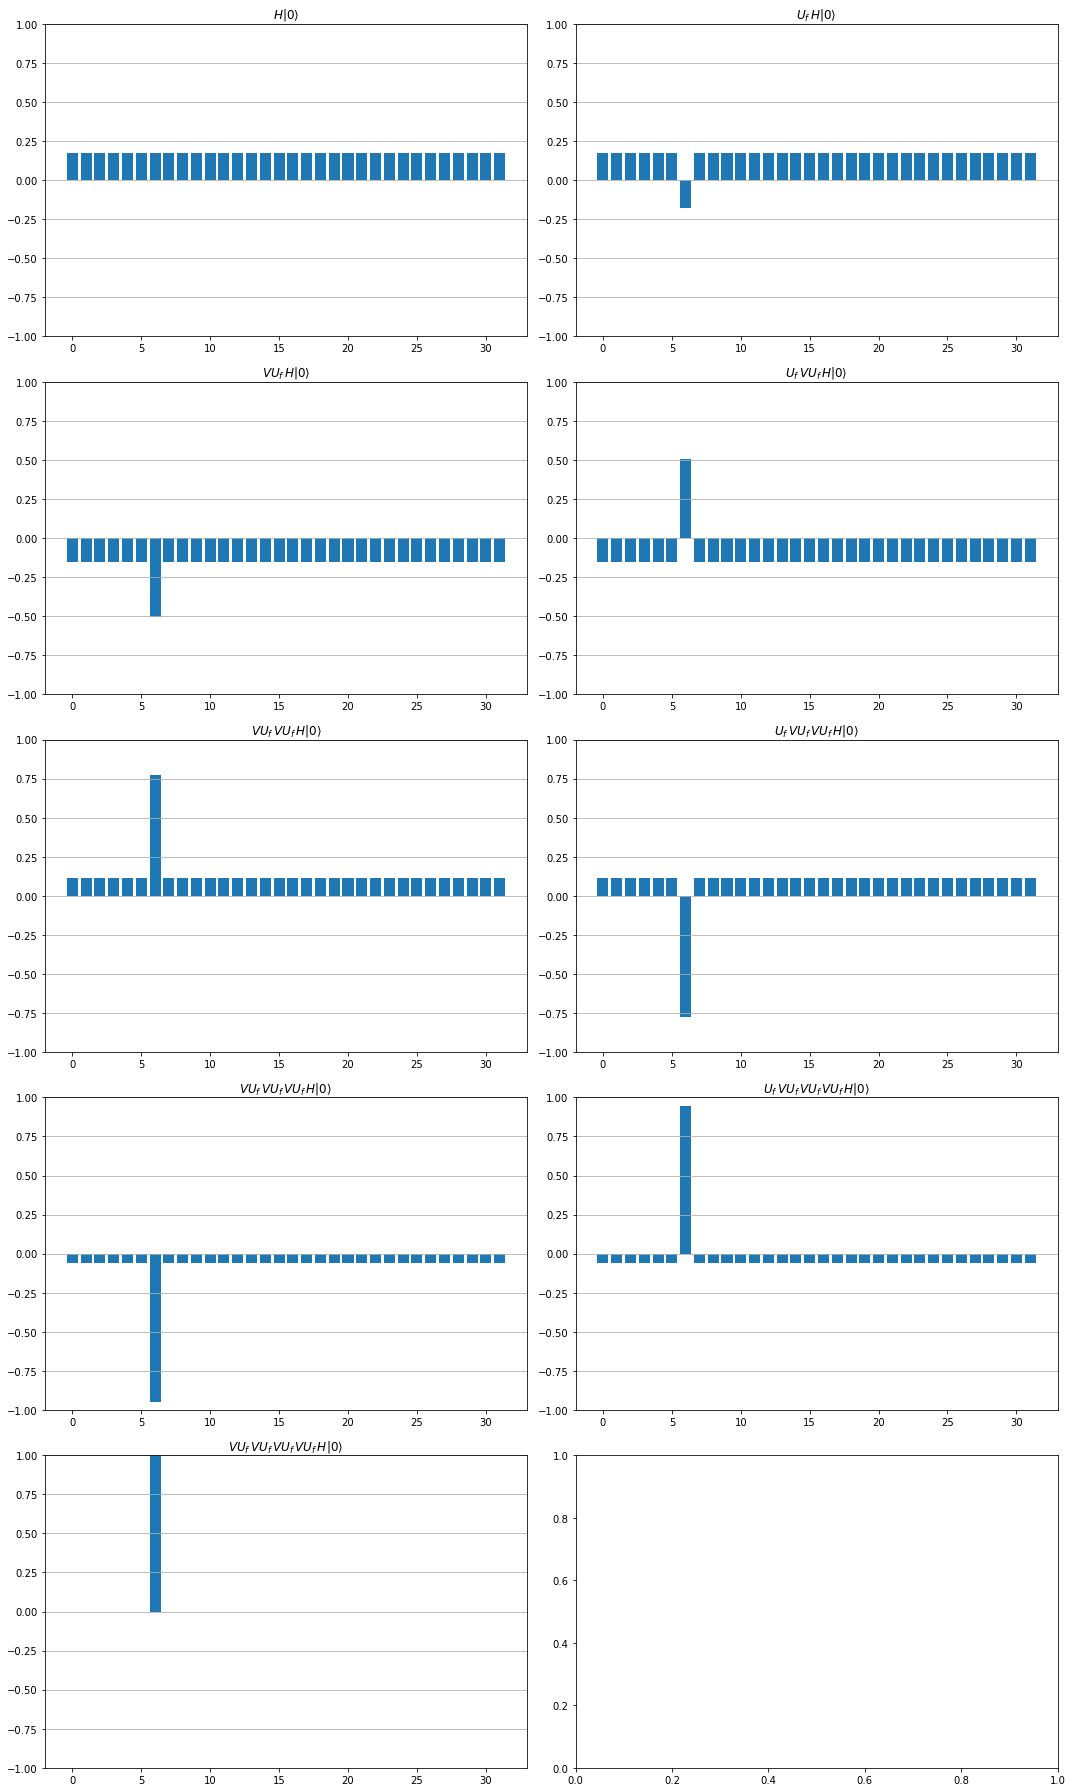

In [134]:
# Grafico das amplitudes de probabilidade com a aplicação de cada operador

fig, axs = plt.subplots(r + 1, 2, figsize=(15, 25))


titulo = r"$H \vert 0 \rangle$"
for i in range(1, len(states)+1):
    ax = axs[(i - 1) // 2, (i - 1) % 2]

    ax.bar(range(2**n), states[i-1])
    ax.set_ylim([-1, 1])
    ax.grid(axis='y')
    ax.set_title(titulo)    
    
    if i % 2 == 1:
        titulo = r"$U_f\,$" + titulo
    else:
        titulo = r"$V$" + titulo
    
fig.tight_layout()
plt.show()